# **Test integration of DP Langevin**

Simple Jupyter notebook testing an adaptation of the Villa Martín/Buendía (VMB)
implementation of the Dornic et al (2005) method of integrating DP/APT-type
Langevin equations using an operator-splitting method. Access to the heavily 
refactored VMB C++ code is provided via a pybind11 wrapper.

See the main README for references.

<hr>

## Preliminaries

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from numpy.typing import NDArray
import dplvn
import initialize

<hr>

## Package `dplvn` info

In [2]:
print(f"dplvn version:  {dplvn.__version__}")

dplvn version:  2025.09.12a3


In [3]:
help(dplvn)

Help on module dplvn:

NAME
    dplvn - 'Dornic' operator-splitting method of integrating DP-type Langevin equations

CLASSES
    pybind11_builtins.pybind11_object(builtins.object)
        BoundaryCondition
        GridDimension
        GridTopology
        InitialCondition
        IntegrationMethod

    class BoundaryCondition(pybind11_builtins.pybind11_object)
     |  Method resolution order:
     |      BoundaryCondition
     |      pybind11_builtins.pybind11_object
     |      builtins.object
     |
     |  Methods defined here:
     |
     |  __eq__(...)
     |      __eq__(self: object, other: object, /) -> bool
     |
     |  __getstate__(...)
     |      __getstate__(self: object, /) -> int
     |
     |  __hash__(...)
     |      __hash__(self: object, /) -> int
     |
     |  __index__(...)
     |      __index__(self: dplvn.BoundaryCondition, /) -> int
     |
     |  __init__(...)
     |      __init__(self: dplvn.BoundaryCondition, value: typing.SupportsInt) -> None
     |
   

In [4]:
help(dplvn.dp)

Help on built-in function dp in module dplvn:

dp(...) method of pybind11_builtins.pybind11_detail_function_record_v1_system_libcpp_abi1 instance
    dp(linear: typing.SupportsFloat = 1.0, quadratic: typing.SupportsFloat = 2.0, diffusion: typing.SupportsFloat = 0.1, noise: typing.SupportsFloat = 1.0, t_max: typing.SupportsFloat = 100.0, dx: typing.SupportsFloat = 0.5, dt: typing.SupportsFloat = 0.01, random_seed: typing.SupportsInt = 1, grid_dimension: dplvn.GridDimension = <GridDimension.D2: 2>, grid_size: collections.abc.Sequence[typing.SupportsInt] = None, n_cells: typing.SupportsInt = 4096, grid_topology: dplvn.GridTopology = <GridTopology.BOUNDED: 1>, boundary_condition: dplvn.BoundaryCondition = <BoundaryCondition.FLOATING: 1>, initial_condition: dplvn.InitialCondition = <InitialCondition.RANDOM_UNIFORM: 1>, integration_method: dplvn.IntegrationMethod = <IntegrationMethod.RUNGE_KUTTA: 2>) -> numpy.typing.NDArray[numpy.float64]

    Demo application of the Dornic method



<hr>

## Demo

Perform demo integration of a DP Langevin on a 64 $\times$ 64 grid 
(4096 cells) with simple choices of parameters.

In [5]:
result: NDArray = dplvn.dp(
    linear=1.0, quadratic=2.0, diffusion=0.1, noise=1.0, 
    t_max=10.0, #dx=0.5, dt=0.01
    grid_dimension=dplvn.D1,
    # grid_size=(8,8,),
    # n_cells=64,  
    grid_size=(4096,),
    n_cells=4096,
    grid_topology=dplvn.BOUNDED,
    boundary_condition=dplvn.FLOATING,
    initial_condition=dplvn.RANDOM_UNIFORM,
    integration_method=dplvn.RUNGE_KUTTA
)

linear: 1
quadratic: 2
diffusion: 0.1
noise: 1
t_max: 10
dx: 0.5
dt: 0.01
random_seed: 1
grid_dimension: 1d
n_cells: 4096
grid_size: 4096 
grid_topology: bounded
boundary_condition: floating
initial_condition: random uniform values
integration_method: Runge-Kutta


Simulation results are returned as a `numpy` array with integration time steps
("epochs") in the first column and grid-mean density ("mean_densities") in the
second column. 

In [6]:
type(result), result.shape

(numpy.ndarray, (1002, 2))

In [7]:
epochs: NDArray = result[:, 0]
mean_densities: NDArray = result[:, 1]
epochs[-10:], mean_densities[-10:]

(array([ 9.92,  9.93,  9.94,  9.95,  9.96,  9.97,  9.98,  9.99, 10.  ,
        10.01]),
 array([0.04950738, 0.04941429, 0.0493263 , 0.04935449, 0.04873828,
        0.04902843, 0.04901017, 0.04904578, 0.04978525, 0.04979658]))

<hr>

## Plot results

Plot the time-series of grid-averaged density field.

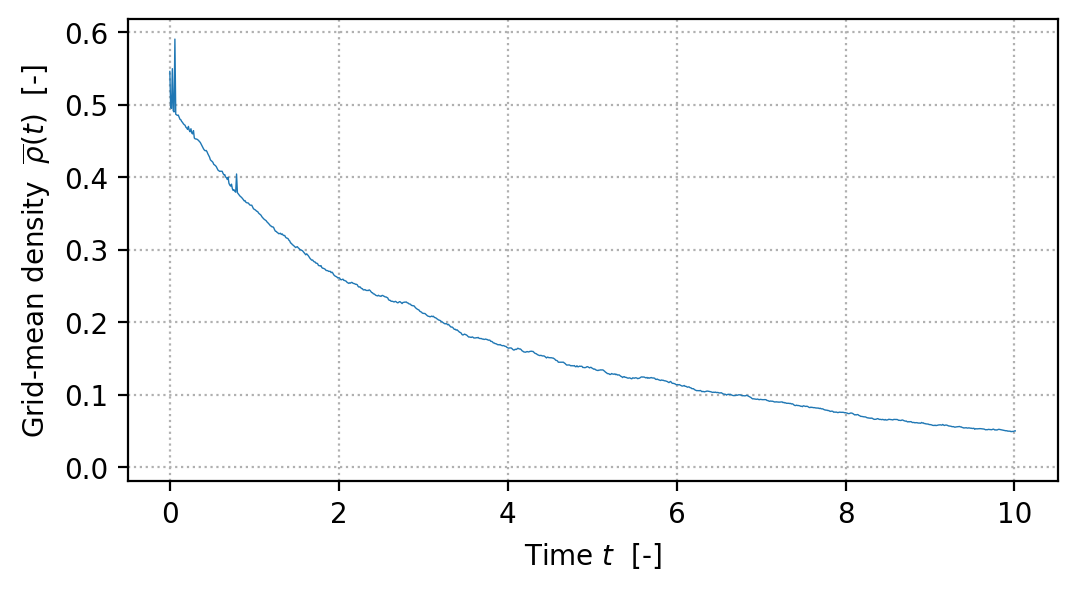

In [8]:
fig = plt.figure(figsize=(6,3))
plt.plot(epochs, mean_densities, "-", lw=0.5,)
plt.xlabel(r"Time $t$  [-]")
plt.ylabel(r"Grid-mean density  $\overline{\rho}(t)$  [-]")
plt.ylim(-0.02, None)
plt.grid(ls=":")

In [9]:
fig.savefig(
    "meandensity_time.png",
    bbox_inches="tight",
    pad_inches=0.05,
    dpi=150,
    format="PNG",
)